In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

In [3]:
setting, num_user = "FedAvg", 40

try: # Skip loading if already loaded
    aggregator_o
except:
    aggregator_o, clients, args_ = set_args(setting, num_user)

# Load models for FAT and FedAvg
save_path_FAT = 'weights/cifar10/230922_baseline_train/FAT/'
save_path_FedAvg = 'weights/cifar10/230922_baseline_train/fedavg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator_o, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator_o, args_)[0]


==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 165.26it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:09<00:00,  4.00it/s]


In [4]:
# Perform 50 rounds of full overfitting on benign data on 200R FAT model
num_rounds = 30
setting = 'FedAvg_adv'
num_users = [1,3,5,10]


test_acc_gather = {}
adv_acc_gather = {}
test_acc_std_gather = {}
adv_acc_std_gather = {}

peturb_prop = 0.25
cutoff_round = 15


save_path_FAT150 = 'weights/cifar10/231031_FAT150round/FAT/'


for num_user in num_users:
    test_acc_gather[num_user] = []
    adv_acc_gather[num_user] = []
    test_acc_std_gather[num_user] = []
    adv_acc_std_gather[num_user] = []
    
    aggregator, clients, args_ = set_args(setting, 40)

    # Test performance of aggregator on data 
    aggregator.load_state(dir_path = save_path_FAT150)
    
    # Trim number of clients
    aggregator.clients = aggregator.clients[0:num_user]
    aggregator.clients_weights = np.divide(aggregator.clients_weights[0:num_user],np.sum(aggregator.clients_weights[0:num_user].numpy()))
    aggregator.n_clients_per_round = num_user
    
    aggregator.update_clients()
    model_FAT = pull_model_from_agg(aggregator)
    model_FAT.eval()
    
    for c in aggregator.clients:
        c.unlearning_flag = True
    
    # Add standard deviation
    acc, adv_acc = get_adv_acc(aggregator_o, model_FAT)

    prev_model = copy.deepcopy(model_FAT)

    print("round", 0 ,"Test acc: ", np.mean(acc), "(", np.std(acc),")", "adv acc: ", 
                  np.mean(adv_acc), "(", np.std(adv_acc),")")
    test_acc_gather[num_user] += [np.mean(acc)]
    adv_acc_gather[num_user] += [np.mean(adv_acc)]
    test_acc_std_gather[num_user] += [np.std(acc)]
    adv_acc_std_gather[num_user] += [np.std(adv_acc)]
    
    # Setting evasion attack parameters
    x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
    x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
    atk_params = PGD_Params()
    atk_params.set_params(batch_size=1, iteration = 5,
                    target = -1, x_val_min = x_min, x_val_max = x_max,
                    step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)
    
     # Assign proportion and attack params
    for i in range(len(aggregator.clients)):
        aggregator.clients[i].set_adv_params(peturb_prop, atk_params)
        aggregator.clients[i].update_advnn()
        aggregator.clients[i].assign_advdataset()
    
    for round in range(1,num_rounds+1):
        
        aggregator.mix()
        model_overfit = pull_model_from_agg(aggregator)
        
        if round%5 == 0:
            
            if round <= cutoff_round:
                for i in range(len(aggregator.clients)):
                    aggregator.clients[i].set_adv_params(peturb_prop, atk_params)
                    aggregator.clients[i].update_advnn()
                    aggregator.clients[i].assign_advdataset()
            else:
                for i in range(len(aggregator.clients)):
                    aggregator.clients[i].reset_dataset()
                

            model_overfit.eval()
            acc, adv_acc = get_adv_acc(aggregator_o, model_overfit)

            print("round", round,"Test acc: ", np.mean(acc), "(", np.std(acc),")", "adv acc: ", 
                  np.mean(adv_acc), "(", np.std(adv_acc),")")
            test_acc_gather[num_user] += [np.mean(acc)]
            adv_acc_gather[num_user] += [np.mean(adv_acc)]
            test_acc_std_gather[num_user] += [np.std(acc)]
            adv_acc_std_gather[num_user] += [np.std(adv_acc)]

    del aggregator, clients, args_

==> Clients initialization..
===> Building data iterators..


 49%|████▉     | 39/80 [00:00<00:00, 173.02it/s]


===> Initializing clients..


100%|██████████| 40/40 [00:17<00:00,  2.35it/s]


round 0 Test acc:  0.7937500134110451 ( 0.06349212552534053 ) adv acc:  0.3503125045448542 ( 0.08783362651903805 )
round 0 Test acc:  0.546875012665987 ( 0.12214713333273672 ) adv acc:  0.17281250329688191 ( 0.06851593804728005 )
round 0 Test acc:  0.5534375116229058 ( 0.10540056039621094 ) adv acc:  0.1721875029616058 ( 0.06327565679356362 )


KeyboardInterrupt: 

In [ ]:
dict_list = [test_acc_gather, adv_acc_gather, test_acc_std_gather, adv_acc_std_gather]

# Directory where you want to save the pickle file
directory = 'saved_results/240813_arue_std/'

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Path to the pickle file
file_path = os.path.join(directory, 'acc_std_gather_list_perturb_02_v2.pkl')
# Pickle the dictionary and save it to the file
with open(file_path, 'wb') as file:
    pickle.dump(dict_list, file)

ValueError: x and y must have same first dimension, but have shapes (7,) and (8,)

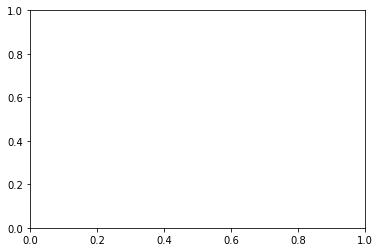

In [ ]:
# Initialize a new figure
plt.figure(figsize=(6, 4))

# X-axis values: 0 to 30 in intervals of 5 (7 points)
x_values = np.arange(0, 35, 5)

# Iterate over each num_user key
for num_user in test_acc_gather.keys():
    # Extract corresponding data for each num_user
    test_acc = test_acc_gather[num_user]
    adv_acc = adv_acc_gather[num_user]
    test_acc_std = test_acc_std_gather[num_user]
    adv_acc_std = adv_acc_std_gather[num_user]
    
    # Plot test accuracy with standard deviation
    plt.plot(x_values, test_acc, label=f'Num User={num_user}')
    plt.fill_between(x_values, np.array(test_acc) - np.array(test_acc_std),
                     np.array(test_acc) + np.array(test_acc_std), alpha=0.2)
    
    # Plot adversarial accuracy with standard deviation (dotted line)
#     plt.plot(x_values, adv_acc, label=f'Adv Accuracy (num_user={num_user})', linestyle=':')
    plt.plot(x_values, adv_acc, linestyle=':')

    plt.fill_between(x_values, np.array(adv_acc) - np.array(adv_acc_std),
                     np.array(adv_acc) + np.array(adv_acc_std), alpha=0.2)

# Add title and labels
plt.title('Test and Adversarial Accuracy with Standard Deviations')
plt.xlabel('X Values')
plt.ylabel('Accuracy')

# Combine legend to remove duplicates and label clarity
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')

# Show the plot
plt.show()